##**Project 2: Modern Low Footprint Cyber Attack Detection**
#### *CSC 180 Intelligent Systems*
#### *California State University, Sacramento*
---
##### Completed by:

*   Bikram Singh
*   Gloria Nikitchuk
*   Austin Melendez
*   Dhruv Sharma

## **Import Useful TensorFlow Functions**

In [1]:
# Written by Dr. Haiquan Chen

%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

## **Data Import**

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#os.chdir('/content/drive/My Drive/CSC180Projects')

In [4]:
df_test = pd.read_csv("./Data/UNSW_NB15_test-set.csv")
df_train = pd.read_csv("./Data/UNSW_NB15_training-set.csv")

#Check shape of data
print("Test data:", df_test.shape)
print("Training data:", df_train.shape)

Test data: (82332, 45)
Training data: (175341, 45)


Data peek


In [5]:
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [6]:
df_test.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [7]:
df_train['proto'].unique()

array(['tcp', 'udp', 'arp', 'ospf', 'icmp', 'igmp', 'rtp', 'ddp',
       'ipv6-frag', 'cftp', 'wsn', 'pvp', 'wb-expak', 'mtp', 'pri-enc',
       'sat-mon', 'cphb', 'sun-nd', 'iso-ip', 'xtp', 'il', 'unas',
       'mfe-nsp', '3pc', 'ipv6-route', 'idrp', 'bna', 'swipe',
       'kryptolan', 'cpnx', 'rsvp', 'wb-mon', 'vmtp', 'ib', 'dgp',
       'eigrp', 'ax.25', 'gmtp', 'pnni', 'sep', 'pgm', 'idpr-cmtp',
       'zero', 'rvd', 'mobile', 'narp', 'fc', 'pipe', 'ipcomp', 'ipv6-no',
       'sat-expak', 'ipv6-opts', 'snp', 'ipcv', 'br-sat-mon', 'ttp',
       'tcf', 'nsfnet-igp', 'sprite-rpc', 'aes-sp3-d', 'sccopmce', 'sctp',
       'qnx', 'scps', 'etherip', 'aris', 'pim', 'compaq-peer', 'vrrp',
       'iatp', 'stp', 'l2tp', 'srp', 'sm', 'isis', 'smp', 'fire', 'ptp',
       'crtp', 'sps', 'merit-inp', 'idpr', 'skip', 'any', 'larp', 'ipip',
       'micp', 'encap', 'ifmp', 'tp++', 'a/n', 'ipv6', 'i-nlsp',
       'ipx-n-ip', 'sdrp', 'tlsp', 'gre', 'mhrp', 'ddx', 'ippc', 'visa',
       'secure-vmtp', 

In [8]:
df_train.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [9]:
df_train.dtypes

id                     int64
dur                  float64
proto                 object
service               object
state                 object
spkts                  int64
dpkts                  int64
sbytes                 int64
dbytes                 int64
rate                 float64
sttl                   int64
dttl                   int64
sload                float64
dload                float64
sloss                  int64
dloss                  int64
sinpkt               float64
dinpkt               float64
sjit                 float64
djit                 float64
swin                   int64
stcpb                  int64
dtcpb                  int64
dwin                   int64
tcprtt               float64
synack               float64
ackdat               float64
smean                  int64
dmean                  int64
trans_depth            int64
response_body_len      int64
ct_srv_src             int64
ct_state_ttl           int64
ct_dst_ltm             int64
ct_src_dport_l

In [10]:
df_train['state'].value_counts()

state
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
PAR        1
URN        1
no         1
Name: count, dtype: int64

## **Data Preprocessing**

In [11]:
# Bikram Singh, 10/1/2024
# Find all the values unique to the test and train sets
proto_train = set(df_train['proto'].unique())
proto_test = set(df_test['proto'].unique())

service_train = set(df_train['service'].unique())
service_test = set(df_test['service'].unique())

state_train = set(df_train['state'].unique())
state_test = set(df_test['state'].unique())

proto1 = proto_train.difference(proto_test)
proto2 = proto_test.difference(proto_train)

service1 = service_train.difference(service_test)
service2 = service_test.difference(service_train)

state1 = state_train.difference(state_test)
state2 = state_test.difference(state_train)

print("Categories in proto column training set that are not in test set: ", proto1)
print("Categories in proto column test set that are not in the training set: ", proto2)

print("Categories in service column training set that are not in test set: ", service1)
print("Categories in service column test set that are not in training set: ", service2)

print("Categories in state column training set that are not in test set: ", state1)
print("Categories in state column test set that are not in training set: ", state2)

Categories in proto column training set that are not in test set:  {'icmp', 'rtp'}
Categories in proto column test set that are not in the training set:  set()
Categories in service column training set that are not in test set:  set()
Categories in service column test set that are not in training set:  set()
Categories in state column training set that are not in test set:  {'no', 'URN', 'PAR', 'ECO'}
Categories in state column test set that are not in training set:  {'CLO', 'ACC'}


In [12]:
# Bikram Singh, 10/1/2024
# Remove all records that contain values unique to train set and test set
proto_values_to_drop_train = ['icmp', 'rtp']
state_values_to_drop_train = ['URN', 'no', 'PAR', 'ECO']
state_values_to_drop_test = ['ACC', 'CLO']

print("Train set: ", df_train.shape)
df_train = df_train.loc[~df_train['proto'].isin(proto_values_to_drop_train)]
print("After dropping proto values in train: ", df_train.shape)

print("Test set: ", df_test.shape)
df_test = df_test.loc[~df_test['state'].isin(state_values_to_drop_test)]
print("After dropping state values in test: ", df_test.shape)

Train set:  (175341, 45)
After dropping proto values in train:  (175325, 45)
Test set:  (82332, 45)
After dropping state values in test:  (82327, 45)


## **Data Cleaning**

In [13]:
# Gloria Nikitchuk, 10/02/2024
# Drop all rows with missing values

print("Train data shape: ", df_train.shape)
df_train.replace("-", np.nan, inplace=True) # looks like all empty values are denoted with "-", so cleaning based on that
df_train_clean = df_train.dropna()
print("Train data after drop: ", df_train_clean.shape)


print("Test data shape: ", df_test.shape)
df_test_clean = df_test.dropna()
df_test_clean.replace("-", np.nan, inplace=True)  # looks like all empty values are denoted with "-", so cleaning based on that
df_test_clean = df_test_clean.dropna()
print("Test data after drop: ", df_test_clean.shape)


Train data shape:  (175325, 45)
Train data after drop:  (81173, 45)
Test data shape:  (82327, 45)
Test data after drop:  (35178, 45)


In [14]:
#Check if there are any nulls remaining
df_train_clean.isna().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [15]:
# Bikram Singh, 10/1/2024
# Normalize numeric features

cols_to_drop = ['id', 'label']

numeric_columns = df_train_clean.select_dtypes(include=['number'])
numeric_column_names = numeric_columns.columns

# Remove the id and label cols
normalized_cols = [col for col in numeric_column_names if col not in cols_to_drop]
# print(normalized_cols)

scaler = MinMaxScaler()
df_train_clean[normalized_cols] = scaler.fit_transform(df_train_clean[normalized_cols])
df_test_clean[normalized_cols] = scaler.fit_transform(df_test_clean[normalized_cols])

df_train_clean.head()

C:\Users\austi\AppData\Local\Temp\ipykernel_11788\3393785127.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_clean[normalized_cols] = scaler.fit_transform(df_train_clean[normalized_cols])


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
3,4,2.802780e-02,tcp,ftp,FIN,0.001144,0.001093,0.000041,0.000053,0.000014,...,0.0,0.039216,0.25,0.25,0.000000,0.016949,0.000000,0.0,Normal,0
11,12,3.488529e-02,tcp,smtp,FIN,0.006344,0.002551,0.004337,0.000151,0.000043,...,0.0,0.019608,0.00,0.00,0.000000,0.000000,0.000000,0.0,Normal,0
15,16,1.666693e-08,udp,snmp,INT,0.000104,0.000000,0.000003,0.000000,0.500000,...,0.0,0.058824,0.00,0.00,0.000000,0.016949,0.000000,0.0,Normal,0
17,18,6.559354e-03,tcp,http,FIN,0.000936,0.000729,0.000059,0.000075,0.000043,...,0.0,0.019608,0.00,0.00,0.033333,0.000000,0.039216,0.0,Normal,0
21,22,5.633690e-03,tcp,http,FIN,0.000936,0.000547,0.000069,0.000018,0.000044,...,0.0,0.000000,0.00,0.00,0.033333,0.016949,0.039216,0.0,Normal,0


In [16]:
# Bikram Singh, 10/1/2024
# Encode categorical features

categorical_cols = df_train_clean.select_dtypes(include=['object'])
print(categorical_cols.columns)

# One-Hot Encoding
df_train_clean = pd.get_dummies(df_train_clean, columns=categorical_cols.columns)
df_test_clean = pd.get_dummies(df_test_clean, columns=categorical_cols.columns)
df_train_clean = df_train_clean.loc[:, df_train_clean.columns.isin(df_test_clean.columns)] #Gloria Nikitchuk, this aligns the columns of the train set with the test set to ensure data shape match


pd.set_option('display.max_columns', None)
df_train_clean.head()

Index(['proto', 'service', 'state', 'attack_cat'], dtype='object')


,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,proto_tcp,proto_udp,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_FIN,state_INT,state_REQ,attack_cat_Backdoor,attack_cat_DoS,attack_cat_Exploits,attack_cat_Fuzzers,attack_cat_Generic,attack_cat_Normal,attack_cat_Reconnaissance,attack_cat_Worms
3,4,2.802780e-02,0.001144,0.001093,0.000041,0.000053,0.000014,0.138393,0.992126,0.000001,0.000150,0.000208,0.000547,1.092583e-02,0.006449,0.000275,0.017249,1.0,0.257772,0.243888,1.0,0.000000,0.000000,0.000000,0.006777,0.043896,0.000000,0.000000,0.000000,0.166667,0.02,0.0,0.0,0.039216,0.25,0.25,0.000000,0.016949,0.000000,0.0,0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
11,12,3.488529e-02,0.006344,0.002551,0.004337,0.000151,0.000043,0.138393,0.992126,0.000092,0.000364,0.005830,0.001459,2.452283e-03,0.005367,0.003456,0.000367,1.0,0.424852,0.200410,1.0,0.087972,0.103000,0.054975,0.652108,0.054184,0.000000,0.000000,0.019608,0.166667,0.00,0.0,0.0,0.019608,0.00,0.00,0.000000,0.000000,0.000000,0.0,0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
15,16,1.666693e-08,0.000104,0.000000,0.000003,0.000000,0.500000,0.995536,0.000000,0.119792,0.000000,0.000000,0.000000,1.429367e-07,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.019578,0.000000,0.000000,0.000000,0.000000,0.333333,0.00,0.0,0.0,0.058824,0.00,0.00,0.000000,0.016949,0.000000,0.0,0,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False
17,18,6.559354e-03,0.000936,0.000729,0.000059,0.000075,0.000043,0.138393,0.992126,0.000007,0.000869,0.000416,0.000365,3.125199e-03,0.003407,0.002257,0.000248,1.0,0.904076,0.718098,1.0,0.080709,0.115373,0.042914,0.032380,0.093964,0.005814,0.000016,0.039216,0.166667,0.00,0.0,0.0,0.019608,0.00,0.00,0.033333,0.000000,0.039216,0.0,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False
21,22,5.633690e-03,0.000936,0.000547,0.000069,0.000018,0.000044,0.995536,0.992126,0.000009,0.000236,0.000416,0.000182,2.516980e-03,0.004044,0.002049,0.000283,1.0,0.620722,0.819917,1.0,0.103597,0.107399,0.069747,0.042922,0.030864,0.005814,0.000000,0.098039,0.166667,0.00,0.0,0.0,0.000000,0.00,0.00,0.033333,0.016949,0.039216,0.0,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False


Data Shaping

In [17]:
# Austin Melendez, 10/3/2024
# Modifying data to x,y format for model training and testing in TensorFlow

# Remove id and label from data being fed into model
df_train_clean.drop('id',axis=1,inplace=True)
df_test_clean.drop('id',axis=1,inplace=True)

#df_train_clean.drop(columns=['label', 'id'], errors='ignore', axis=1, inplace=True)
#df_test_clean.drop(columns=['id'], errors='ignore', axis=1, inplace=True)

# Create x & y for training and testing
x_train, y_train = to_xy(df_train_clean, 'label')
x_test, y_test = to_xy(df_test_clean, 'label')

print(df_train_clean.shape)
print(df_test_clean.shape)

# Check data shape
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

(81173, 66)
(35178, 66)
x_train: (81173, 65)
x_test: (35178, 65)
y_train: (81173, 2)
y_test: (35178, 2)


## **Additonal Features (Feature Importance Analysis)**

In [18]:
#Dhruv Sharma 10/04/2024

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

In [19]:
#Dhruv Sharma 10/04/2024

#Dropping label and separating features and target
fia_X_train = df_train.drop(columns=['label', 'id'], errors='ignore')
fia_y_train = df_train['label']

#Standardize Data
fia_scaler = StandardScaler()
fia_X_scaled = fia_scaler.fit_transform(fia_X_train.select_dtypes(include=[np.number]))

# Logistic regression
fia_log_reg = LogisticRegression(max_iter=1000)
fia_log_reg.fit(fia_X_scaled, fia_y_train)

# Get Feature Importance
fia_importance = np.abs(fia_log_reg.coef_[0])
fia_feature_names = fia_X_train.select_dtypes(include=[np.number]).columns

In [20]:
#Dhruv Sharma 10/04/2024

#Create Dataframe to display feature importance
fia_importance_df = pd.DataFrame({
    'Feature': fia_feature_names,
    'Importance': fia_importance
})

In [21]:
#Dhruv Sharma 10/04/2024

# Sort Features by importance
fia_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Select top 10 most important features
top_10_features = fia_importance_df.head(10)

# Display results
print("Top 10 Important Features:")
print(top_10_features)

#Gloria Nikitchuk
top_feature_indices = [df_train_clean.columns.get_loc(feature) for feature in top_10_features['Feature']]

fia_x_train = x_train[:, top_feature_indices]
fia_x_test = x_test[:, top_feature_indices]

Top 10 Important Features:
           Feature  Importance
9            dload   19.896034
16            swin    8.180561
11           dloss    7.688995
4           dbytes    5.922143
7             dttl    5.455064
24           dmean    3.194702
37      ct_srv_dst    2.660659
10           sloss    2.629194
3           sbytes    2.430172
32  ct_dst_src_ltm    2.428555


## **FCNN Models (Fully-Connected Neural Network)**

Imports

In [22]:
# Austin Melendez, 10/4/2024
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report


In [27]:
# Austin Melendez, 10/3/2024
# FCNN Models

# Model hyperparameters
fcnn_activations = ['relu', 'sigmoid', 'tanh']
fcnn_optimizers = ['adam', 'sgd']
fcnn_configurations = [(activator, optimizer) for activator in fcnn_activations for optimizer in fcnn_optimizers]

# Model builder
def fcnn_build_model(activation, optimizer_name):

  # Build network
  model = Sequential()

  model.add(Dense(64, input_dim=x_train.shape[1], activation=activation)) # Input Layer

  model.add(Dense(32, activation=activation)) # Hidden Layer

  model.add(Dense(16, activation=activation)) # Hidden Layer

  model.add(Dense(8, activation=activation)) # Hidden Layer

  model.add(Dense(y_train.shape[1], activation="sigmoid")) # Output Layer

  model.compile(loss='categorical_crossentropy', optimizer=optimizer_name) # Compile Model

  return model

In [25]:
# Austin Melendez, 10/4/2024

# Function written by Gloria Nikitchuk, adapted to rapidly test FCNN hyperparamaters too
fcnn_models = {}
fcnn_model_save_path = "./fcnn_model"
fcnn_best_model_path = ""

if not os.path.exists(fcnn_model_save_path):
    os.makedirs(fcnn_model_save_path)

for a, o in fcnn_configurations:
    print("Current model:", a, o)

    checkpointer = ModelCheckpoint(filepath="dnn/best_weights.keras", verbose=0, save_best_only=True) # save best model

    # Run model a few times to avoid a local optimum
    for i in range(2):
      model = fcnn_build_model(a, o)

      earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

      model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[earlystop,checkpointer],verbose=2,epochs=100)

    model.load_weights('dnn/best_weights.keras') # load weights from best model

    print('Training finished...running next model \n')

    model_save_name = f'model_{a}_{o}.keras'
    model.save(os.path.join(fcnn_model_save_path, model_save_name))

    fcnn_models[f'{a} {o} model'] = model

Current model: relu adam
Epoch 1/100
2537/2537 - 8s - 3ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 2/100
2537/2537 - 14s - 5ms/step - loss: 0.0090 - val_loss: 1.1921e-07
Epoch 3/100
2537/2537 - 13s - 5ms/step - loss: 1.1921e-07 - val_loss: 1.1921e-07
Epoch 4/100
2537/2537 - 13s - 5ms/step - loss: 1.1921e-07 - val_loss: 1.1921e-07
Epoch 5/100
2537/2537 - 13s - 5ms/step - loss: 1.1921e-07 - val_loss: 1.1921e-07
Epoch 6/100
2537/2537 - 13s - 5ms/step - loss: 1.1921e-07 - val_loss: 1.1921e-07
Epoch 7/100
2537/2537 - 14s - 6ms/step - loss: 1.1921e-07 - val_loss: 1.1921e-07
Epoch 7: early stopping
Epoch 1/100
2537/2537 - 8s - 3ms/step - loss: nan - val_loss: nan
Epoch 2/100
2537/2537 - 11s - 4ms/step - loss: nan - val_loss: nan
Epoch 3/100
2537/2537 - 13s - 5ms/step - loss: nan - val_loss: nan
Epoch 4/100
2537/2537 - 12s - 5ms/step - loss: nan - val_loss: nan
Epoch 5/100
2537/2537 - 13s - 5ms/step - loss: nan - val_loss: nan
Epoch 5: early stopping
Training finished...running next model 

In [26]:
# Austin Melendez, 10/4/2024
# Function written by Gloria Nikitchuk, adapted to rapidly test FCNN hyperparamaters too
y_true = np.argmax(y_test,axis=1)
target_names = ['Normal', 'Attack']
best_model_name = None
best_f1_score = float('-inf')

for i, model in enumerate(fcnn_models.keys()):
    pred = fcnn_models[model].predict(x_test)
    pred =  np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)

    score = metrics.f1_score(y_true, pred, average="weighted")

    if ((score > best_f1_score) & (score <= 0.99)):
        best_f1_score = score
        best_model_name = model
        best_pred = pred

    # Print f1 score for current model
    print("F1 Score for: " + model)
    print(score)

print(best_pred)

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
F1 Score for: relu adam model
1.0
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score for: relu sgd model
0.6113065492682941
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score for: sigmoid adam model
0.9999715726819302
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score for: sigmoid sgd model
1.0
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score for: tanh adam model
1.0
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
F1 Score for: tanh sgd model
0.8050380928767361
[0 0 0 ... 0 0 0]


In [28]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, best_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 9622     2]
 [ 7249 18305]]


Best model:  tanh sgd model
Best model classification report: 
              precision    recall  f1-score   support

      Normal       0.57      1.00      0.73      9624
      Attack       1.00      0.72      0.83     25554

    accuracy                           0.79     35178
   macro avg       0.79      0.86      0.78     35178
weighted avg       0.88      0.79      0.81     35178

[[ 9622     2]
 [ 7249 18305]]
Ploting confusion matrix


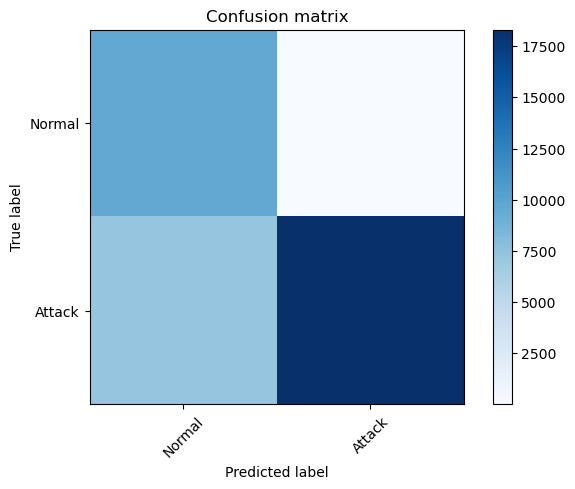

In [29]:
# Austin Melendez, 10/4/2024
# Print out classification report of the best model
print("Best model: ", best_model_name)
print("Best model classification report: ")
print(metrics.classification_report(y_true, best_pred, target_names=target_names))

# Compute confusion matrix
cm = confusion_matrix(y_true, best_pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, target_names)
plt.show()

In [30]:
# Austin Melendez, 10/4/2024

# Print all best model statistics
print("Best Model:", best_model_name)
score = metrics.recall_score(y_true, best_pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.log_loss(y_test, best_pred)
print("Log loss score: {}".format(score))
score = metrics.accuracy_score(y_true, best_pred)
print("Accuracy score: {}".format(score))
score = metrics.precision_score(y_true, best_pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.f1_score(y_true, best_pred, average="weighted")
print("F1 score: {}".format(score))

Best Model: tanh sgd model
Recall score: 0.7938768548524646
Log loss score: 7.429431199172449
Accuracy score: 0.7938768548524646
Precision score: 0.8823708809249917
F1 score: 0.8050380928767361


Test to see if adding Feature Importance improves our best model.

In [32]:
# Austin Melendez, 10/5/2024
# Build network
model = Sequential()

model.add(Dense(64, input_dim=fia_x_train.shape[1], activation="tanh")) # Input Layer

model.add(Dense(32, activation="tanh")) # Hidden Layer

model.add(Dense(16, activation="tanh")) # Hidden Layer

model.add(Dense(8, activation="tanh")) # Hidden Layer

model.add(Dense(y_train.shape[1], activation="sigmoid")) # Output Layer

model.compile(loss='binary_crossentropy', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.keras", verbose=0, save_best_only=True) # save best model

model.fit(fia_x_train,y_train,validation_data=(fia_x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

model.load_weights('dnn/best_weights.keras') # load weights from best model

Epoch 1/100
2537/2537 - 10s - 4ms/step - loss: 0.2266 - val_loss: 0.5040
Epoch 2/100
2537/2537 - 5s - 2ms/step - loss: 0.1416 - val_loss: 0.5159
Epoch 3/100
2537/2537 - 7s - 3ms/step - loss: 0.1371 - val_loss: 0.4746
Epoch 4/100
2537/2537 - 9s - 4ms/step - loss: 0.1331 - val_loss: 0.4814
Epoch 5/100
2537/2537 - 11s - 4ms/step - loss: 0.1285 - val_loss: 0.4308
Epoch 6/100
2537/2537 - 12s - 5ms/step - loss: 0.1237 - val_loss: 0.4351
Epoch 7/100
2537/2537 - 9s - 4ms/step - loss: 0.1190 - val_loss: 0.4257
Epoch 8/100
2537/2537 - 12s - 5ms/step - loss: 0.1140 - val_loss: 0.3533
Epoch 9/100
2537/2537 - 12s - 5ms/step - loss: 0.1086 - val_loss: 0.3331
Epoch 10/100
2537/2537 - 11s - 4ms/step - loss: 0.1021 - val_loss: 0.2839
Epoch 11/100
2537/2537 - 12s - 5ms/step - loss: 0.0946 - val_loss: 0.2616
Epoch 12/100
2537/2537 - 10s - 4ms/step - loss: 0.0878 - val_loss: 0.2339
Epoch 13/100
2537/2537 - 5s - 2ms/step - loss: 0.0832 - val_loss: 0.2170
Epoch 14/100
2537/2537 - 6s - 2ms/step - loss: 0.080

## **Best Model (FCNN w/ Feature Importance Analysis)**

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Classification report: 
              precision    recall  f1-score   support

      Normal       1.00      0.71      0.83      9624
      Attack       0.90      1.00      0.95     25554

    accuracy                           0.92     35178
   macro avg       0.95      0.85      0.89     35178
weighted avg       0.93      0.92      0.91     35178

Best Model: tanh sgd model
Recall score: 0.9192108704303826
Log loss score: 2.9119353838157633
Accuracy score: 0.9192108704303826
Precision score: 0.9269625224543839
F1 score: 0.914415150755727
[[ 6799  2825]
 [   17 25537]]
Ploting confusion matrix


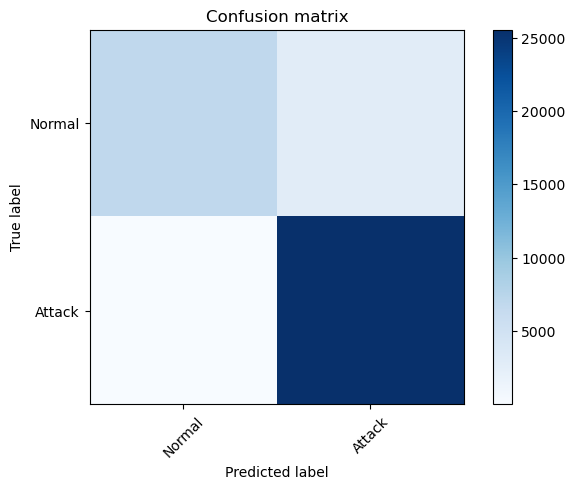

In [33]:
# Austin Melendez, 10/4/2024
# Print out classification report of the best model
pred = model.predict(fia_x_test)
pred =  np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)

print("Classification report: ")
print(metrics.classification_report(y_true, pred, target_names=target_names))

# Print all best model statistics
print("Best Model:", best_model_name)
score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))
score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))
score = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score))
score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.f1_score(y_true, pred, average="weighted")
print("F1 score: {}".format(score))

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, target_names)
plt.show()

## **Additonal Features (Multi-class Classification)**


In [34]:
# Dhruv Sharma 10/04/2024

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
# Dhruv Sharma 10/04/2024

# Separate Features and Labels
mcc_X = df_train.drop(columns=['label', 'id'], errors='ignore')
mcc_y = df_train['label']

# Split data into training and validation sets (80% train, 20% validation)
mcc_X_train, mcc_X_val, mcc_y_train, mcc_y_val = train_test_split(mcc_X, mcc_y, test_size=0.2, random_state=42)

# Define numeric and categorical features
mcc_numeric_features = mcc_X.select_dtypes(include=[np.number]).columns
mcc_categorical_features = mcc_X.select_dtypes(exclude=[np.number]).columns

In [36]:
# Dhruv Sharma 10/04/2024

# Create Pipeline
mcc_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), mcc_numeric_features),
        ('cat', OneHotEncoder(), mcc_categorical_features)
    ])

# Train a Logistic Regression Model without specifying `multi_class`
mcc_model = Pipeline(steps=[
    ('preprocessor', mcc_preprocessor),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000))  # No need to specify multi_class explicitly
])

# Fit the model to the training data
mcc_model.fit(mcc_X_train, mcc_y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['proto', 'service', 'state', 'attack_cat'], dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [37]:
# Dhruv Sharma 10/04/2024

# Predict on validation set
mcc_y_val_pred = mcc_model.predict(mcc_X_val)

# Classification report (precision, recall, f1-score for each class)
print("Classification Report:\n")
print(classification_report(mcc_y_val, mcc_y_val_pred))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11213
           1       1.00      1.00      1.00     23852

    accuracy                           1.00     35065
   macro avg       1.00      1.00      1.00     35065
weighted avg       1.00      1.00      1.00     35065



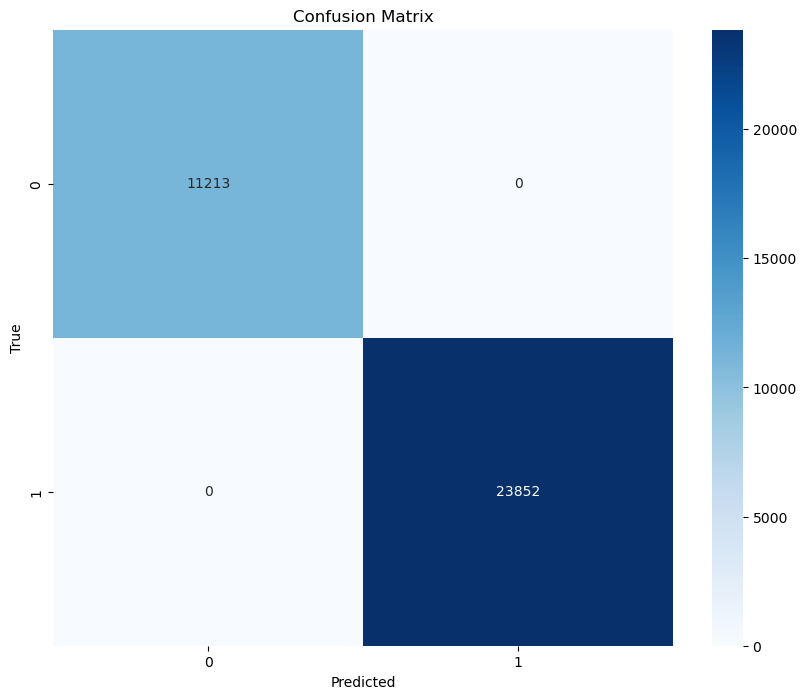

In [38]:
# Dhruv Sharma 10/04/2024

# Confusion matrix
mcc_cm = confusion_matrix(mcc_y_val, mcc_y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(mcc_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **CNN Models (Convolutional Neural Network)**


In [39]:
#imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import os
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Data Shaping

In [40]:
# Gloria Nikitchuk, 10/03/2024

# Define batch_size and # of epochs
cnn_batch_size = 256
cnn_epochs = 100
img_rows, img_cols = 65,1

print(x_train.shape)
print(x_test.shape)

# reshape data
cnn_x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
cnn_x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

# reshaped data using extra features
cnn_x_train_fia = fia_x_train.reshape(fia_x_train.shape[0], 10, img_cols, 1)
cnn_x_test_fia = fia_x_test.reshape(fia_x_test.shape[0], 10, img_cols, 1)

cnn_y_train = y_train
cnn_y_test = y_test

# check data shape
print("x_train: {}".format(cnn_x_train.shape))
print("x_test: {}".format(cnn_x_test.shape))

print("y_train: {}".format(cnn_y_train.shape))
print("y_test: {}".format(cnn_y_test.shape))

print("x_train_fia: {}".format(cnn_x_train_fia.shape))
print("x_test_fia: {}".format(cnn_x_test_fia.shape))

(81173, 65)
(35178, 65)
x_train: (81173, 65, 1, 1)
x_test: (35178, 65, 1, 1)
y_train: (81173, 2)
y_test: (35178, 2)
x_train_fia: (81173, 10, 1, 1)
x_test_fia: (35178, 10, 1, 1)


Model Build


In [41]:
# Gloria Nikitchuk, 10/04/2024

# Model hyperparameters
cnn_activations = ['relu', 'sigmoid', 'tanh']
cnn_optimizers = ['adam', 'sgd']

cnn_configurations = [(activator, optimizer) for activator in cnn_activations for optimizer in cnn_optimizers]

#CNN model builder
def _cnn_build_model(activation, optimizer_name):
    # Create a Sequential model
    cnn = Sequential()

    # First convolutional layer
    cnn.add(Conv2D(128, kernel_size=(3, 1), strides=(1, 1),
                    activation=activation,
                    input_shape=(10, 1, 1))) #changed to 10 for fia

    # Pooling layer with reduced height
    cnn.add(MaxPooling2D(pool_size=(2, 1)))

    # Second convolutional layer
    cnn.add(Conv2D(64, kernel_size=(3, 1), strides=(1, 1),
                    activation=activation))

    # Pooling layer
    cnn.add(MaxPooling2D(pool_size=(2, 1)))

    # Flatten the output before fully connected layers
    cnn.add(Flatten())

    # Dropout layer to prevent overfitting
    cnn.add(Dropout(0.2))

    # Dense layer
    cnn.add(Dense(2, activation="sigmoid"))

    # Compile the model using the specified optimizer
    cnn.compile(loss="binary_crossentropy", optimizer=optimizer_name, metrics=['accuracy'])

    return cnn


In [42]:
# Gloria Nikitchuk, 10/04/2024

cnn_models = {}
cnn_model_save_path = "./cnn_model"
cnn_best_rmse = float('inf')
cnn_best_model_path = ""

if not os.path.exists(cnn_model_save_path):
    os.makedirs(cnn_model_save_path)

for activation, optimizer in cnn_configurations:
    model = _cnn_build_model(activation, optimizer)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    print("\nNow training {} {} model:\n".format(activation, optimizer))
    history = model.fit(cnn_x_train_fia, cnn_y_train, epochs=cnn_epochs, batch_size=cnn_batch_size, validation_data=(cnn_x_test_fia, cnn_y_test), callbacks=[early_stopping])

    # cnn_model = model.predict(cnn_x_test_fia)
    model_save_name = f'model_{activation}_{optimizer}.keras'
    model.save(os.path.join(cnn_model_save_path, model_save_name))

    cnn_models[f'{activation} {optimizer} model'] = model



Now training relu adam model:

Epoch 1/100


c:\Users\austi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


318/318 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8496 - loss: 0.3443 - val_accuracy: 0.8748 - val_loss: 0.2783
Epoch 2/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9702 - loss: 0.0992 - val_accuracy: 0.9167 - val_loss: 0.2094
Epoch 3/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9733 - loss: 0.0769 - val_accuracy: 0.9192 - val_loss: 0.1716
Epoch 4/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9755 - loss: 0.0674 - val_accuracy: 0.9236 - val_loss: 0.1381
Epoch 5/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9772 - loss: 0.0621 - val_accuracy: 0.9516 - val_loss: 0.1270
Epoch 6/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9776 - loss: 0.0625 - val_accuracy: 0.9334 - val_loss: 0.1338
Epoch 7/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9778 - loss: 0.0604 - val_accuracy: 0.9196 - val_loss: 0.1509
Epoch 8/100
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9781 - loss: 0.0591 - val_accuracy: 0.91

In [43]:
# Gloria Nikitchuk, 10/04/2024

target_names = ['Normal', 'Attack']
y_test_labels = np.argmax(cnn_y_test, axis=1)
best_model_name = None
best_f1_score = 0

for i, model_name in enumerate(cnn_models.keys()):
    cnn_model = cnn_models[model_name].predict(cnn_x_test_fia)
    predicted_classes = (cnn_model[:, 1] > 0.5).astype(int)

    # classification report
    report = classification_report(y_test_labels, predicted_classes, target_names=target_names,output_dict=True)
    report_str = classification_report(y_test_labels, predicted_classes, target_names=target_names)

    current_f1_score = report['accuracy']
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_model_name = model_name

    # print report for the current model
    print(f"Report for: {model_name}")
    print(report_str + "\n\n")



1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Report for: relu adam model
              precision    recall  f1-score   support

      Normal       1.00      0.71      0.83      9624
      Attack       0.90      1.00      0.95     25554

    accuracy                           0.92     35178
   macro avg       0.95      0.85      0.89     35178
weighted avg       0.93      0.92      0.91     35178



1100/1100 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Report for: relu sgd model
              precision    recall  f1-score   support

      Normal       0.73      0.71      0.72      9624
      Attack       0.89      0.90      0.90     25554

    accuracy                           0.85     35178
   macro avg       0.81      0.81      0.81     35178
weighted avg       0.85      0.85      0.85     35178



1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Report for: sigmoid adam model
              precision    recall  f1-score   support

      Normal       0.99      0.73      0.84      9624
      Attack      

c:\Users\austi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\austi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\austi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\austi\anaconda3\Lib\site-packag

1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Report for: tanh adam model
              precision    recall  f1-score   support

      Normal       1.00      0.71      0.83      9624
      Attack       0.90      1.00      0.95     25554

    accuracy                           0.92     35178
   macro avg       0.95      0.85      0.89     35178
weighted avg       0.93      0.92      0.91     35178



1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Report for: tanh sgd model
              precision    recall  f1-score   support

      Normal       0.64      0.71      0.67      9624
      Attack       0.89      0.85      0.87     25554

    accuracy                           0.81     35178
   macro avg       0.76      0.78      0.77     35178
weighted avg       0.82      0.81      0.81     35178





Best F1 score:  0.9251520836886691
Best model:  sigmoid adam model
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
[[ 7031  2593]
 [   40 25514]]


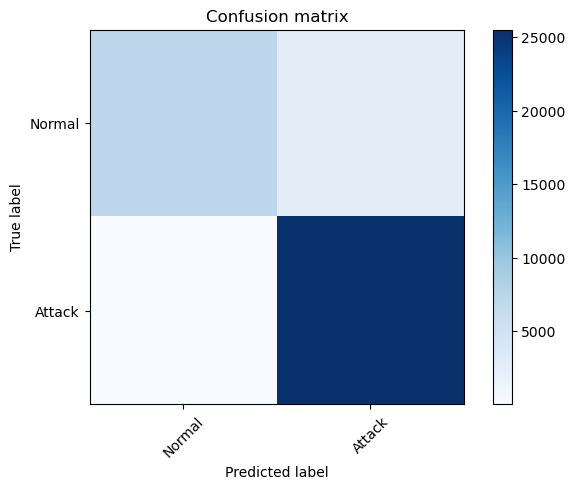

In [44]:
# Gloria Nikitchuk, 10/04/2024

# plotting the confusion matrix for the best model
print("Best F1 score: ", best_f1_score)
print("Best model: ",best_model_name)
cnn_model = cnn_models[best_model_name].predict(cnn_x_test_fia)
cnn_predicted_classes = (cnn_model[:, 1] > 0.5).astype(int)

# plot confusion matrix
cnn_conf_matrix = confusion_matrix(y_test_labels, cnn_predicted_classes)
print(cnn_conf_matrix)
plot_confusion_matrix(cnn_conf_matrix, target_names) #this is profs method

In [45]:
# Gloria Nikitchuk, 10/04/2024
# plotting the model summary for the best model

cnn_models[best_model_name].summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 8, 1, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 1, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,848 (296.29 KB)

 Trainable params: 25,282 (98.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,566 (197.53 KB)